In [64]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import warnings

In [65]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [66]:
def print_stats(predictions, labels_):
    print("Accuracy = {}".format(accuracy_score(labels_, predictions)))
    print("Precision = {}".format(precision_score(labels_, predictions)))
    print("Recall = {}".format(recall_score(labels_, predictions)))
    print("F1 = {}".format(f1_score(labels_, predictions)))
    print("Weighted F1 = {}".format(f1_score(labels_, predictions, average="weighted")))

In [67]:
# Configuration
TP_RANGE = 60  # 4 graphs per minute
FP_RANGE = 60  # 4 graphs per minute
WINDOW_SIZE = 15 * 4  # 4 graphs per minute
DYNAMIC_FAULTS = ["node-drain", "pod-autoscaler", "pod-delete"]
STATIC_FAULTS = ["node-cpu-hog", "node-memory-hog", "pod-cpu-hog", "pod-memory-hog", "pod-network-latency"]
NODE_FAULTS = ["node-cpu-hog", "node-memory-hog", "node-drain"]

In [68]:
data = list(glob("../data/**/features/baseline.pickle"))

In [69]:
df = pd.DataFrame()
for file in data:
    df = pd.concat([df, pd.read_pickle(file)])

df["request_count"] = df["request_count"].astype(float)
df["request_count_5xx"] = df["request_count_5xx"].astype(float)

df = df[~df.index.duplicated(keep=False)]

df.fillna(0, inplace=True)

print(df.shape)

(28797, 10)


In [70]:
df.head()

,request_count,request_count_5xx,request_duration_min,request_duration_max,request_duration_average,request_duration_percentile_50.0,request_duration_percentile_90.0,request_duration_percentile_95.0,request_duration_deviation,request_duration_variance
2024-02-10 00:00:00,1.820833,0.0,39.772159,49.25903,45.698252,47.020918,49.259030,49.25903,3.569976,12.744728
2024-02-10 00:00:15,1.820833,0.0,39.772159,49.25903,45.268654,47.020918,49.259030,49.25903,3.711632,13.776211
2024-02-10 00:00:30,1.716667,0.0,39.772159,49.25903,44.863246,47.020918,49.259030,49.25903,3.768974,14.205166
2024-02-10 00:00:45,1.716667,0.0,39.772159,49.25903,44.435679,47.020918,49.259030,49.25903,3.755323,14.102454
2024-02-10 00:01:00,1.716667,0.0,39.772159,49.25903,44.008111,41.592227,47.817676,49.25903,3.692440,13.634114


### Labels

In [71]:
labels = pd.read_csv("../data/labels_revised.csv")

In [72]:
labels["experiment_created_at"] = pd.to_datetime(labels["experiment_created_at"])
labels["experiment_started_at"] = pd.to_datetime(labels["experiment_started_at"])
labels["experiment_finished_at"] = pd.to_datetime(labels["experiment_finished_at"])

labels["fault_started_at"] = pd.to_datetime(labels["fault_started_at"])
labels["fault_finished_at"] = pd.to_datetime(labels["fault_finished_at"])

anomalies = pd.DataFrame()
for idx, row in labels.iterrows():
    df_ = df.loc[row["started_at"]:row["finished_at"]]
    df_["fault_name"] = row["fault_name"]
    anomalies = pd.concat([anomalies, df_])

In [73]:
y = pd.Series([0 if idx not in anomalies.index else 1 for idx, row in df.iterrows()], index=df.index)
y_label = pd.Series(["normal" if idx not in anomalies.index else anomalies.loc[idx]["fault_name"] for idx, row in df.iterrows()], index=df.index)
print(y.shape)

(28797,)


In [74]:
print(f"Samples: {y.shape}")
print(f"Healthy: {y[y == 0].shape}")
print(f"Anomalous: {y[y == 1].shape}")

Samples: (28797,)
Healthy: (27393,)
Anomalous: (1404,)


### Normalize

In [75]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

X = pd.DataFrame()
for c in df.columns:
    X[c] = absolute_maximum_scale(df[c])

print(X.shape)

(28797, 10)


In [76]:
X.head()

,request_count,request_count_5xx,request_duration_min,request_duration_max,request_duration_average,request_duration_percentile_50.0,request_duration_percentile_90.0,request_duration_percentile_95.0,request_duration_deviation,request_duration_variance
2024-02-10 00:00:00,0.256908,0.0,0.132078,0.065093,0.083930,0.087495,0.065093,0.065093,0.013899,0.000193
2024-02-10 00:00:15,0.256908,0.0,0.132078,0.065093,0.083141,0.087495,0.065093,0.065093,0.014450,0.000209
2024-02-10 00:00:30,0.242210,0.0,0.132078,0.065093,0.082397,0.087495,0.065093,0.065093,0.014673,0.000215
2024-02-10 00:00:45,0.242210,0.0,0.132078,0.065093,0.081611,0.087495,0.065093,0.065093,0.014620,0.000214
2024-02-10 00:01:00,0.242210,0.0,0.132078,0.065093,0.080826,0.077394,0.063189,0.065093,0.014375,0.000207


### TimeSeriesSplit

In [77]:
X_train = df[(df.index >= pd.Timestamp("2024-02-10 16:47:02")) & (df.index <= pd.Timestamp("2024-02-11 10:00:00"))]
Y_train = np.array([y for idx, y in enumerate(y) if
                    pd.Timestamp("2024-02-10 16:47:02") <= df.index[idx] <= pd.Timestamp("2024-02-11 10:00:00")])

X_val = df[(df.index >= pd.Timestamp("2024-02-11 10:00:00")) & (df.index < pd.Timestamp("2024-02-13 06:00:00"))]
Y_val = np.array([y for idx, y in enumerate(y) if
                  pd.Timestamp("2024-02-11 10:00:00") <= df.index[idx] < pd.Timestamp("2024-02-13 06:00:00")])
X_val["label"] = Y_val

idx_anomalies = [idx for idx, y in enumerate(Y_val) if y == 1]
X_val_balanced = X_val.iloc[idx_anomalies]
idx_healthy = X_val.index.difference(X_val.index[idx_anomalies])
X_val_balanced = pd.concat([X_val_balanced, X_val.loc[idx_healthy].sample(len(idx_anomalies))])
Y_val_balanced = np.array(X_val_balanced["label"])
X_val_balanced = X_val_balanced.drop(columns=["label"])
X_val = X_val.drop(columns=["label"])

X_test = df[df.index >= pd.Timestamp("2024-02-13 06:00:00")]
Y_test = np.array([y for idx, y in enumerate(y) if df.index[idx] >= pd.Timestamp("2024-02-13 06:00:00")])

In [78]:
print(X_val_balanced.shape)
print(X_val_balanced.shape)
print(Y_val_balanced[Y_val_balanced == 1].shape)
print(Y_val_balanced[Y_val_balanced == 0].shape)

(1446, 10)
(1446, 10)
(723,)
(723,)


### Model

In [79]:
model = MLPClassifier(solver="adam", activation="relu", alpha=1e-3, hidden_layer_sizes=(100, 25, 25), random_state=1, validation_fraction=0.5)

In [80]:
# Train the model
model.fit(X_val_balanced, Y_val_balanced)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 25, 25), random_state=1,
              validation_fraction=0.5)

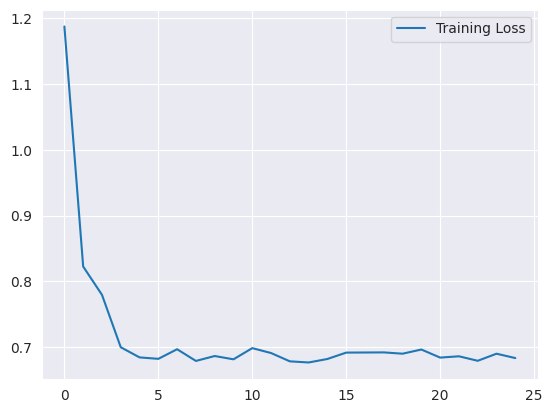

In [81]:
plt.plot(model.loss_curve_, label="Training Loss")
plt.legend()

plt.show()

In [82]:
# Detect anomalies
preds = model.predict(X_test)

In [83]:
print_stats(preds, Y_test)

Accuracy = 0.8257936507936507
Precision = 0.037833190025795355
Recall = 0.06461086637298091
F1 = 0.04772234273318872
Weighted F1 = 0.846269211532084


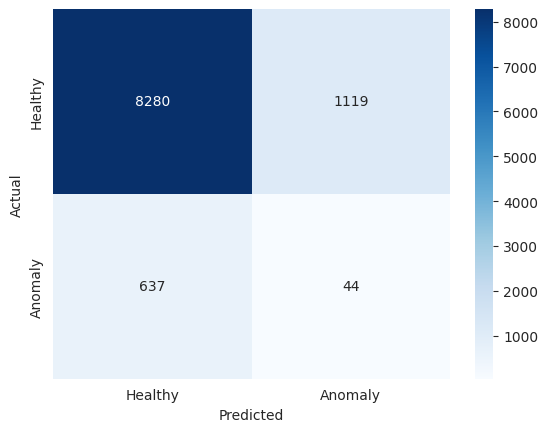

In [84]:
ax = sns.heatmap(confusion_matrix(Y_test, preds), annot=True, cmap="Blues", fmt="d")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

ax.xaxis.set_ticklabels(['Healthy','Anomaly'])
ax.yaxis.set_ticklabels(['Healthy','Anomaly'])

plt.show()